# Market Analysis & Trend Prediction for Land Transactions
This notebook builds a complete, decision-grade market analysis and ML forecasting pipeline for land investments in Bugesera. It covers data engineering, visualization, modeling, evaluation, and future price projections.

**Objectives**
- Identify the most profitable locations to invest
- Detect market price trends
- Explain key factors influencing land price
- Predict future price progression

In [1]:
# Imports & configuration
import warnings
warnings.filterwarnings("ignore")

from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

sns.set_theme(style="whitegrid")
plt.rcParams["figure.figsize"] = (10, 6)

## Data Loading
Load the Bugesera market transactions dataset.

In [2]:
# Load dataset
primary_path = Path("bugesera_sample_market_trends.csv")
if not primary_path.exists():
    primary_path = Path("dataset/bugesera_sample_market_trends.csv")

df_raw = pd.read_csv(primary_path)

# Normalize columns
normalized_cols = [c.strip().lstrip("\ufeff") for c in df_raw.columns]
df_raw.columns = normalized_cols

df_raw = df_raw.rename(columns={c: c.lower() for c in df_raw.columns})

print("Loaded rows:", len(df_raw))
print("Columns:", df_raw.columns.tolist())
display(df_raw.head())

# Use the entire dataset (no province-level balanced sampling)
df = df_raw.copy()

print("Using all available data. Sample distribution by province:")
print(df["provincename"].value_counts())

Loaded rows: 264838
Columns: ['provincename', 'districtname', 'sectorname', 'cellname', 'village', 'upi', 'size', 'land_use_name_kinyarwanda', 'transaction_type_name', 'sale_price', 'start_date', 'year']


,provincename,districtname,sectorname,cellname,village,upi,size,land_use_name_kinyarwanda,transaction_type_name,sale_price,start_date,year
0,Eastern,Bugesera,Gashora,Biryogo,Kivugiza,5/07/01/01/1004,231.0,Gutura,Transfer by Voluntary Sale,450000.0,02/09/2023,NaN
1,Eastern,Bugesera,Gashora,Biryogo,Kanyonyomba,5/07/01/01/1015,341.0,Gutura,Transfer by Voluntary Sale,500000.0,28/03/2023,NaN
2,Eastern,Bugesera,Gashora,Biryogo,Biryogo,5/07/01/01/1039,116.0,Gutura,Transfer by Voluntary Sale,2800000.0,28/04/2023,NaN
3,Eastern,Bugesera,Gashora,Biryogo,Kagarama,5/07/01/01/104,1276.0,Ubuhinzi,Transfer by Voluntary Sale,3000000.0,10/08/2022,NaN
4,Eastern,Bugesera,Gashora,Biryogo,Kagarama,5/07/01/01/106,492.0,Ubuhinzi,Transfer by Voluntary Sale,3550000.0,19/12/2023,NaN


Using all available data. Sample distribution by province:
provincename
Eastern        83605
Kigali City    72394
Southern       37843
Northern       36654
Western        34342
Name: count, dtype: int64


## Data Cleaning
Clean missing `Year` and `start_date`, convert dates, remove duplicates, and standardize numeric fields. Each step is explained inline.

In [3]:
# Data cleaning

# Work on a copy
df_clean = df.copy()

# Standardize column names
df_clean.columns = [c.strip() for c in df_clean.columns]

# Parse dates (day-first to match dataset formatting)
df_clean["start_date"] = pd.to_datetime(df_clean["start_date"], errors="coerce", dayfirst=True)

# Convert numeric columns
for col in ["sale_price", "size", "Year"]:
    if col in df_clean.columns:
        df_clean[col] = pd.to_numeric(df_clean[col], errors="coerce")

# Fill missing Year from start_date if available
if "Year" in df_clean.columns:
    df_clean["Year"] = df_clean["Year"].fillna(df_clean["start_date"].dt.year)

# Drop rows with missing critical fields
critical_cols = [
    "sale_price", "size", "start_date",
    "provincename", "districtname", "sectorname", "cellname"
]
critical_cols = [c for c in critical_cols if c in df_clean.columns]
df_clean = df_clean.dropna(subset=critical_cols)

# Keep positive values only
if "sale_price" in df_clean.columns:
    df_clean = df_clean[df_clean["sale_price"] > 0]
if "size" in df_clean.columns:
    df_clean = df_clean[df_clean["size"] > 0]

# Clip extreme outliers to reduce skew
for col in ["sale_price", "size"]:
    if col in df_clean.columns and len(df_clean) > 0:
        lo, hi = df_clean[col].quantile([0.01, 0.99])
        df_clean[col] = df_clean[col].clip(lo, hi)

# Remove duplicates by UPI, keep latest transaction
if "upi" in df_clean.columns:
    df_clean = df_clean.sort_values("start_date").drop_duplicates(subset=["upi"], keep="last")

print("After cleaning:", df_clean.shape)
display(df_clean.head())

After cleaning: (244687, 12)


,provincename,districtname,sectorname,cellname,village,upi,size,land_use_name_kinyarwanda,transaction_type_name,sale_price,start_date,year
244950,Western,Rubavu,Busasamana,Rusura,Cyamabuye,3/03/02/07/798,1077.0,Ubuhinzi,Transfer by Voluntary Sale,1100000.0,2022-01-01,NaN
246690,Western,Rubavu,Kanzenze,Kanyirabigogo,Giramata,3/03/06/01/1170,416.0,Gutura,Transfer by Voluntary Sale,2500000.0,2022-01-01,NaN
254475,Western,Rubavu,Rugerero,Muhira,Kasonga,3/03/12/04/3119,370.0,Ubuhinzi,Transfer by Voluntary Sale,5000000.0,2022-01-01,NaN
261369,Western,Rutsiro,Kigeyo,Nyagahinika,Nteko,3/02/03/03/7890,6865.0,Ubuhinzi,Transfer by Voluntary Sale,5000000.0,2022-01-01,NaN
245580,Western,Rubavu,Cyanzarwe,Ryabizige,Musene,3/03/03/08/4008,597.0,Ubuhinzi,Transfer by Voluntary Sale,1000000.0,2022-01-01,NaN


## Feature Engineering
Create derived features including `price_per_size`, time features, area-level aggregations, rolling averages, and handle outliers.

In [4]:
# Feature engineering

df_feat = df_clean.copy()

# Time features
df_feat["year"] = df_feat["start_date"].dt.year
df_feat["month"] = df_feat["start_date"].dt.month
df_feat["quarter"] = df_feat["start_date"].dt.quarter
df_feat["year_month"] = df_feat["start_date"].dt.to_period("M").astype(str)

# Size features
df_feat["size_log"] = np.log1p(df_feat["size"])

# Price per size for analysis (not used as model feature to avoid leakage)
df_feat["price_per_size"] = df_feat["sale_price"] / df_feat["size"].replace(0, np.nan)
if "price_per_size" in df_feat.columns:
    lo, hi = df_feat["price_per_size"].quantile([0.01, 0.99])
    df_feat["price_per_size"] = df_feat["price_per_size"].clip(lo, hi)

# Historical aggregates (shifted to prevent leakage)
df_feat = df_feat.sort_values("start_date")
df_feat["sector_hist_avg_price"] = df_feat.groupby("sectorname")["sale_price"].transform(lambda s: s.expanding().mean().shift(1))
df_feat["cell_hist_avg_price"] = df_feat.groupby("cellname")["sale_price"].transform(lambda s: s.expanding().mean().shift(1))
df_feat["sector_hist_txn"] = df_feat.groupby("sectorname").cumcount()
df_feat["cell_hist_txn"] = df_feat.groupby("cellname").cumcount()

# Fill historical NaNs with overall mean
overall_mean_price = df_feat["sale_price"].mean()
for col in ["sector_hist_avg_price", "cell_hist_avg_price"]:
    df_feat[col] = df_feat[col].fillna(overall_mean_price)

print("After feature engineering:", df_feat.shape)
display(df_feat.head())

After feature engineering: (244687, 21)


,provincename,districtname,sectorname,cellname,village,upi,size,land_use_name_kinyarwanda,transaction_type_name,sale_price,...,year,month,quarter,year_month,size_log,price_per_size,sector_hist_avg_price,cell_hist_avg_price,sector_hist_txn,cell_hist_txn
244950,Western,Rubavu,Busasamana,Rusura,Cyamabuye,3/03/02/07/798,1077.0,Ubuhinzi,Transfer by Voluntary Sale,1100000.0,...,2022,1,1,2022-01,6.982863,1021.355617,5.188048e+06,5.188048e+06,0,0
262230,Western,Rutsiro,Mukura,Kagusa,Gako,3/02/06/04/3080,4938.0,Ubuhinzi,Transfer by Voluntary Sale,500000.0,...,2022,1,1,2022-01,8.504918,101.255569,5.188048e+06,5.188048e+06,0,0
255190,Western,Rubavu,Rugerero,Rugerero,Nyantomvu,3/03/12/05/4557,2504.0,Gutura,Transfer by Voluntary Sale,2000000.0,...,2022,1,1,2022-01,7.826044,798.722045,5.188048e+06,5.188048e+06,0,0
262227,Western,Rutsiro,Mukura,Kagusa,Bucyeye,3/02/06/04/2204,2654.0,Ubuhinzi,Transfer by Voluntary Sale,1000000.0,...,2022,1,1,2022-01,7.884200,376.789751,5.000000e+05,5.000000e+05,1,1
247218,Western,Rubavu,Mudende,Bihungwe,Mwirima,3/03/07/01/553,1686.0,Ubuhinzi,Transfer by Voluntary Sale,6000000.0,...,2022,1,1,2022-01,7.430707,3558.718861,5.188048e+06,5.188048e+06,0,0


## Visualization
Explore distributions, relationships, and spatial/temporal patterns. Each chart is followed by insights.

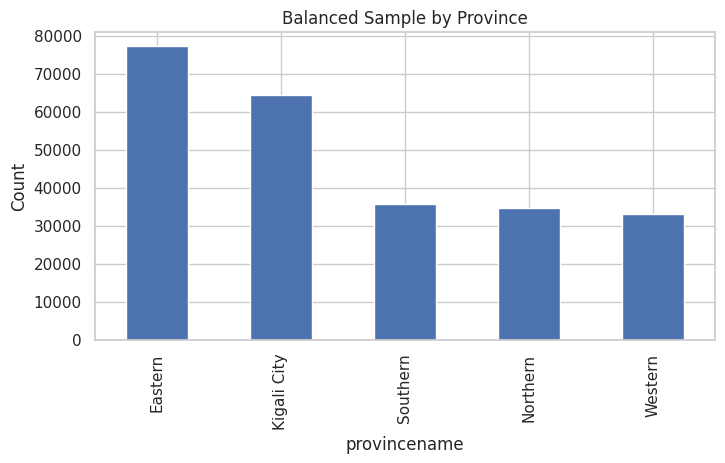

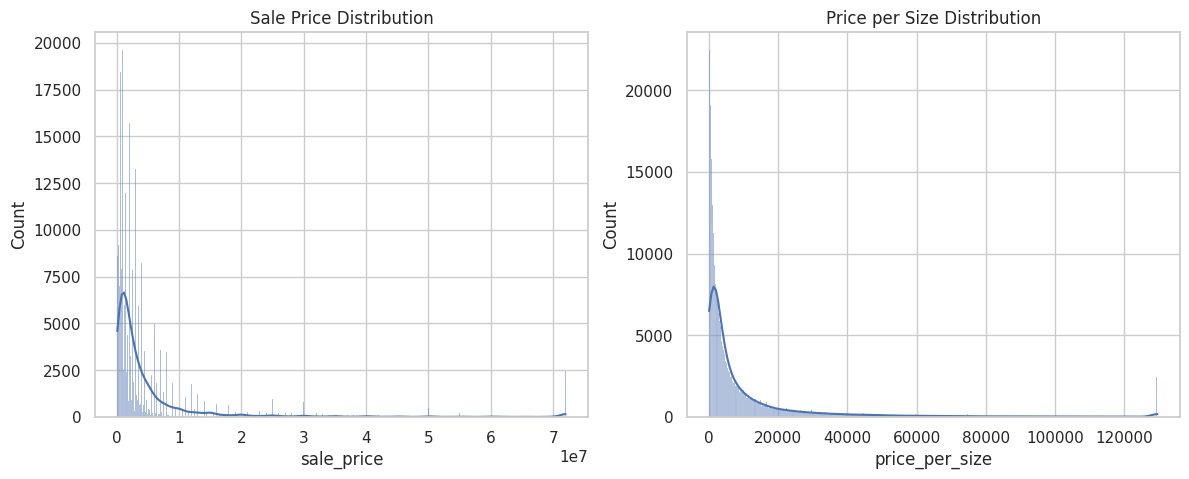

Insight: Balanced sampling reduces province bias; distributions show overall price spread.


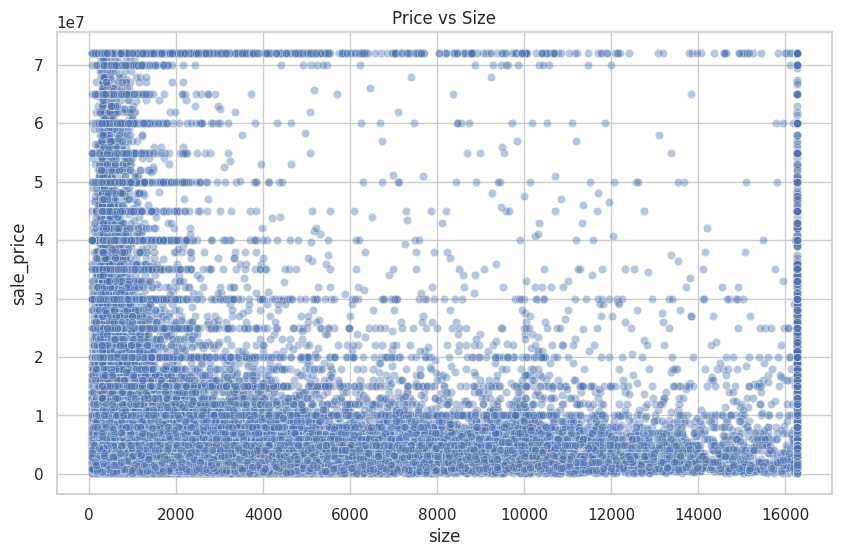

Insight: Observe whether price scales proportionally with land size.


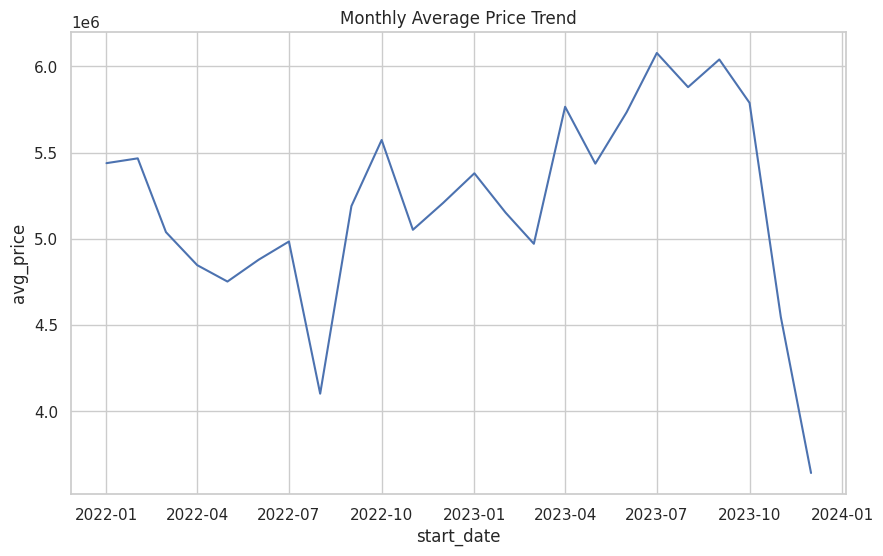

Insight: Trend line reveals market direction over time.


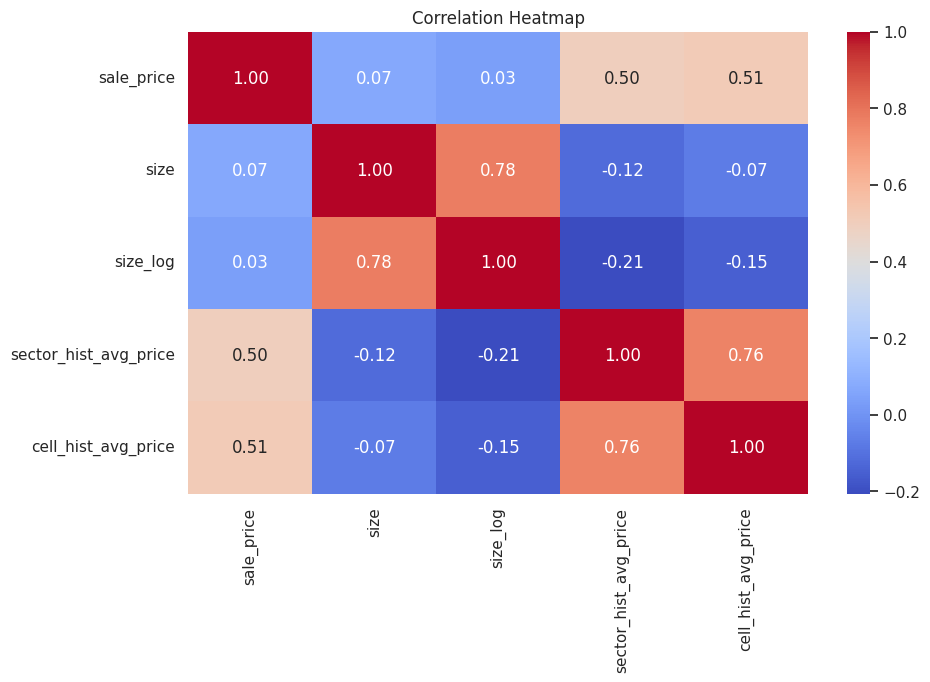

In [5]:
# Balanced sample check
plt.figure(figsize=(8, 4))
df_feat["provincename"].value_counts().plot(kind="bar", title="Balanced Sample by Province")
plt.ylabel("Count")
plt.show()

# Price distribution
fig, axes = plt.subplots(1, 2, figsize=(14, 5))
sns.histplot(df_feat["sale_price"], kde=True, ax=axes[0])
axes[0].set_title("Sale Price Distribution")
sns.histplot(df_feat["price_per_size"].dropna(), kde=True, ax=axes[1])
axes[1].set_title("Price per Size Distribution")
plt.show()
print("Insight: Balanced sampling reduces province bias; distributions show overall price spread.")

# Price vs size scatter
sns.scatterplot(data=df_feat, x="size", y="sale_price", alpha=0.4)
plt.title("Price vs Size")
plt.show()
print("Insight: Observe whether price scales proportionally with land size.")

# Monthly trend
monthly = df_feat.groupby(df_feat["start_date"].dt.to_period("M")).agg(avg_price=("sale_price", "mean")).reset_index()
monthly["start_date"] = monthly["start_date"].dt.to_timestamp()
sns.lineplot(data=monthly, x="start_date", y="avg_price")
plt.title("Monthly Average Price Trend")
plt.show()
print("Insight: Trend line reveals market direction over time.")

# Correlation heatmap (numeric)
numeric_cols = ["sale_price", "size", "size_log", "sector_hist_avg_price", "cell_hist_avg_price"]
corr = df_feat[numeric_cols].corr()
sns.heatmap(corr, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Heatmap")
plt.show()

## Market Insights
Compute profitability, growth, volatility, liquidity, land-use impact, and transaction-type effects.

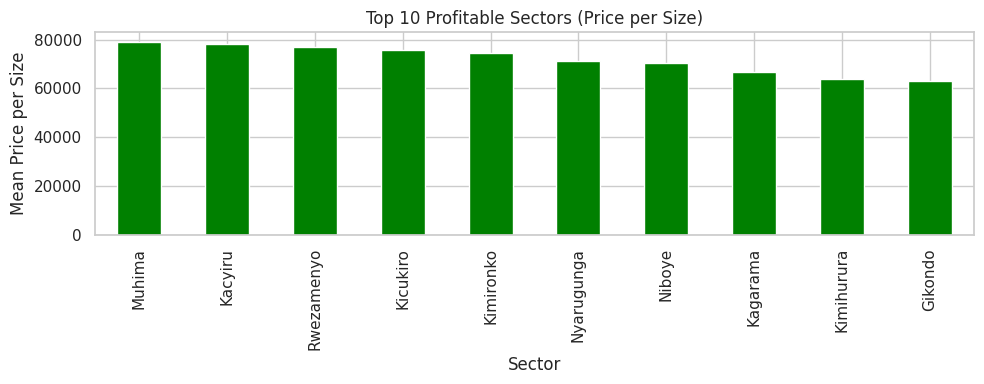

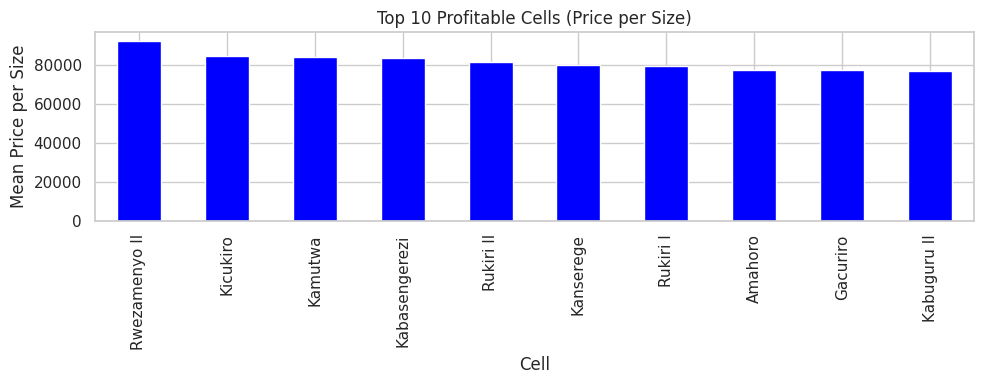

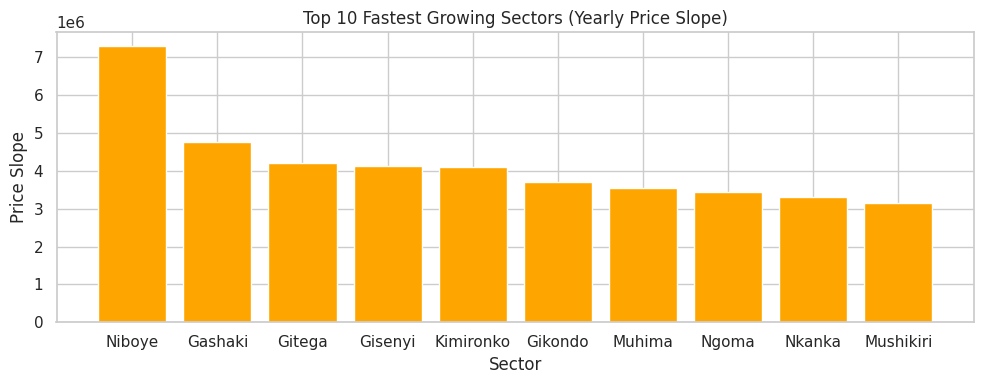

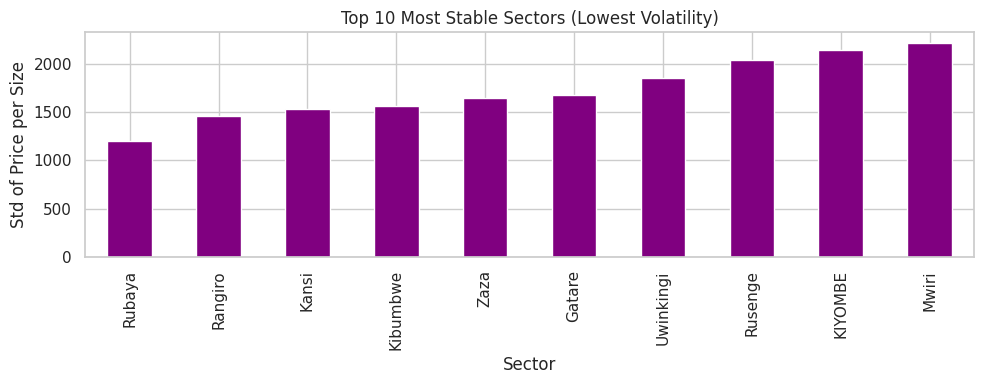

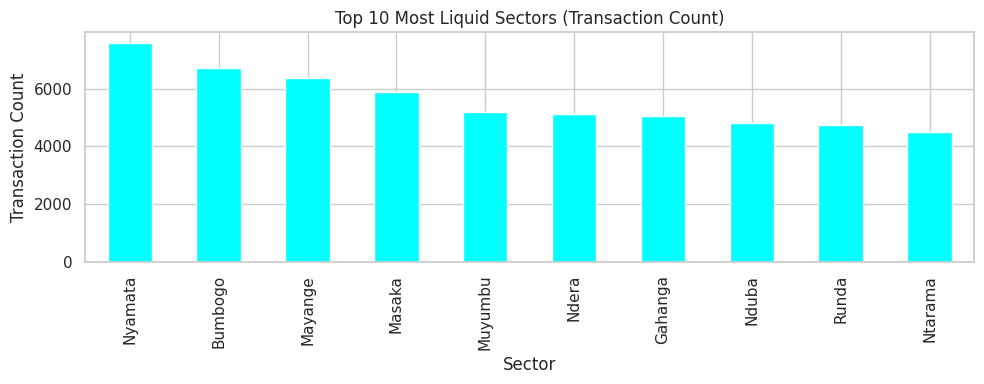

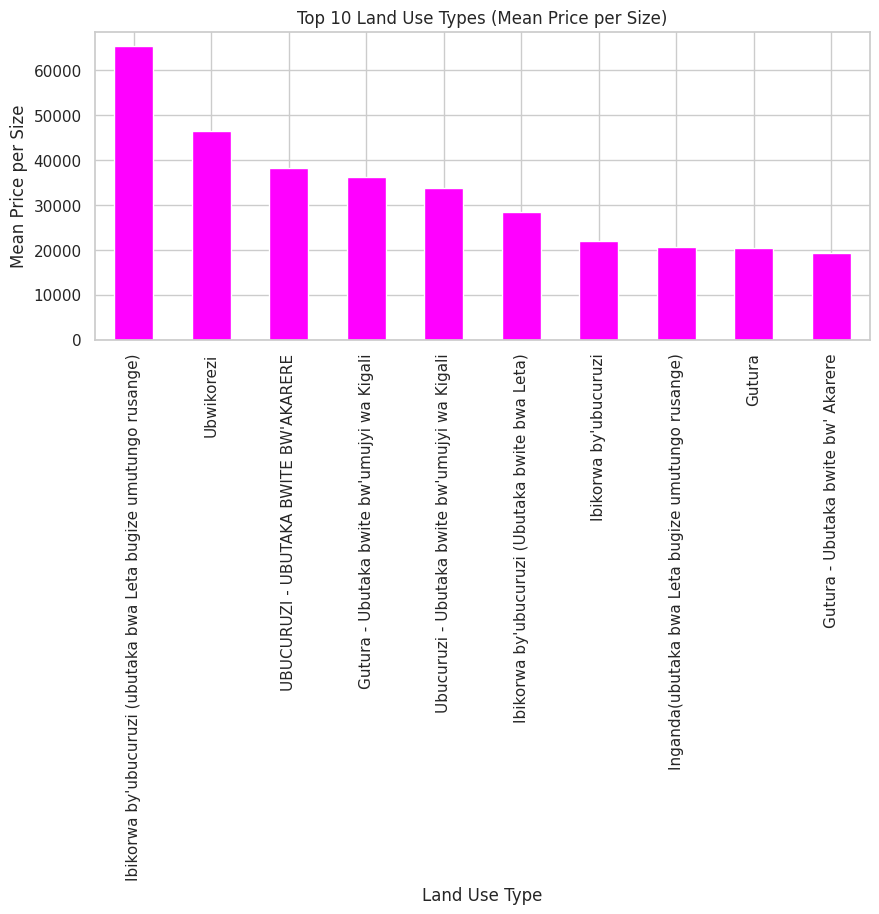

In [6]:
# Market insights (visualized)

# Top profitable sectors and cells by price_per_size (analysis only)
top_sectors_profit = df_feat.groupby("sectorname")["price_per_size"].mean().sort_values(ascending=False).head(10)
top_cells_profit = df_feat.groupby("cellname")["price_per_size"].mean().sort_values(ascending=False).head(10)
plt.figure(figsize=(10, 4))
top_sectors_profit.plot(kind="bar", color="green")
plt.title("Top 10 Profitable Sectors (Price per Size)")
plt.ylabel("Mean Price per Size")
plt.xlabel("Sector")
plt.tight_layout()
plt.show()
plt.figure(figsize=(10, 4))
top_cells_profit.plot(kind="bar", color="blue")
plt.title("Top 10 Profitable Cells (Price per Size)")
plt.ylabel("Mean Price per Size")
plt.xlabel("Cell")
plt.tight_layout()
plt.show()

# Fastest growing sectors by yearly price trend (linear slope)
yearly_sector = df_feat.groupby(["sectorname", "year"])["sale_price"].mean().reset_index()
growth_scores = []
for sector, group in yearly_sector.groupby("sectorname"):
    if group["year"].nunique() < 2:
        continue
    slope = np.polyfit(group["year"], group["sale_price"], 1)[0]
    growth_scores.append((sector, slope))
growth_df = pd.DataFrame(growth_scores, columns=["sectorname", "price_slope"]).sort_values("price_slope", ascending=False)
plt.figure(figsize=(10, 4))
plt.bar(growth_df["sectorname"].head(10), growth_df["price_slope"].head(10), color="orange")
plt.title("Top 10 Fastest Growing Sectors (Yearly Price Slope)")
plt.ylabel("Price Slope")
plt.xlabel("Sector")
plt.tight_layout()
plt.show()

# Volatility by sector (std of price_per_size)
volatility = df_feat.groupby("sectorname")["price_per_size"].std().sort_values(ascending=True)
plt.figure(figsize=(10, 4))
volatility.head(10).plot(kind="bar", color="purple")
plt.title("Top 10 Most Stable Sectors (Lowest Volatility)")
plt.ylabel("Std of Price per Size")
plt.xlabel("Sector")
plt.tight_layout()
plt.show()

# Liquidity indicator (transaction frequency)
liquidity = df_feat["sectorname"].value_counts().rename("txn_count")
plt.figure(figsize=(10, 4))
liquidity.head(10).plot(kind="bar", color="cyan")
plt.title("Top 10 Most Liquid Sectors (Transaction Count)")
plt.ylabel("Transaction Count")
plt.xlabel("Sector")
plt.tight_layout()
plt.show()

# Land use impact on price
land_use_price = df_feat.groupby("land_use_name_kinyarwanda")["price_per_size"].mean().sort_values(ascending=False)
plt.figure(figsize=(10, 4))
land_use_price.head(10).plot(kind="bar", color="magenta")
plt.title("Top 10 Land Use Types (Mean Price per Size)")
plt.ylabel("Mean Price per Size")
plt.xlabel("Land Use Type")
plt.tight_layout()
plt.show()

## Investment Ranking
Rank investment zones using a composite score (profitability, growth, liquidity, volatility).

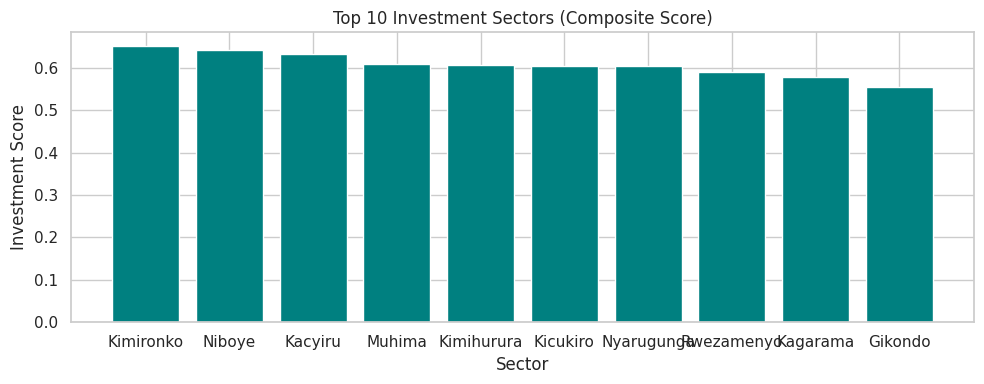

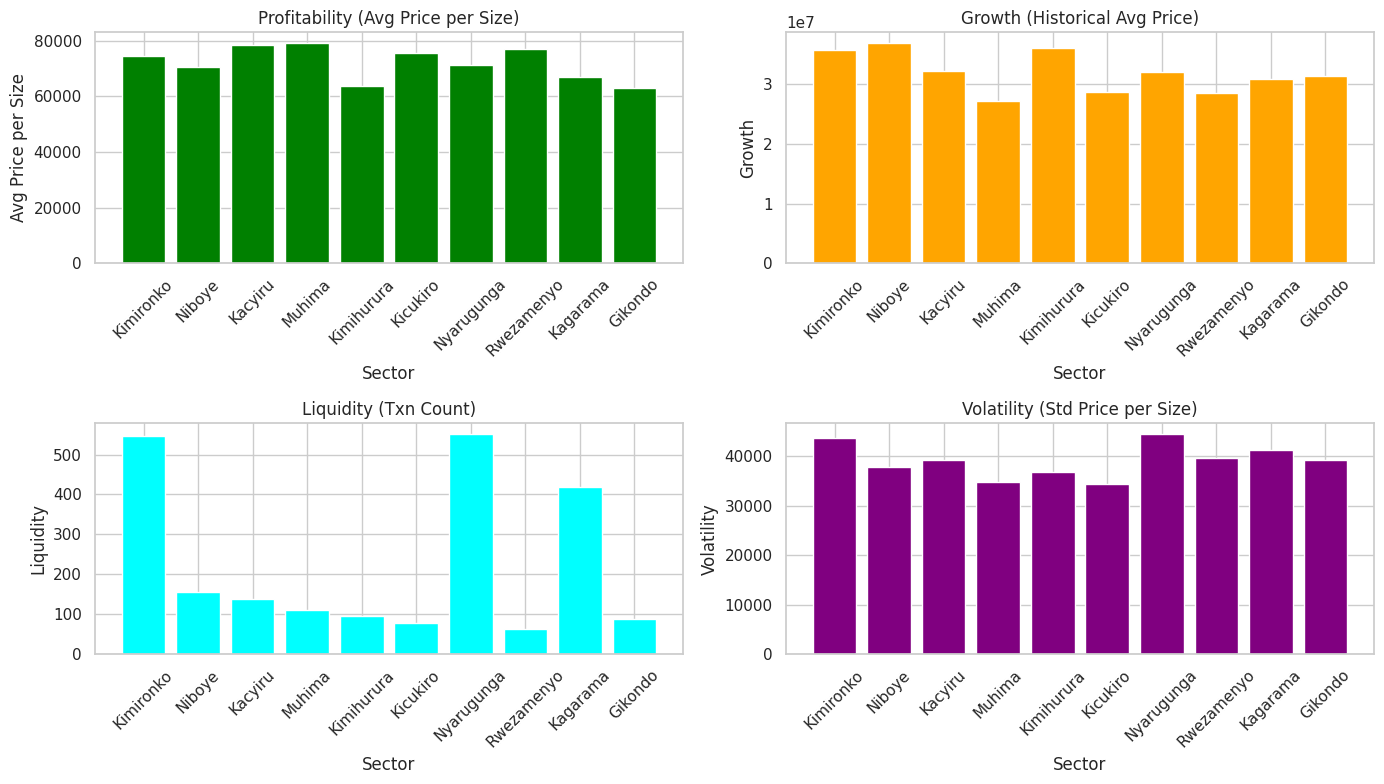

In [7]:
# Composite scoring by sector (profitability + growth + liquidity + stability)
sector_stats = df_feat.groupby("sectorname").agg(
    avg_pps=("price_per_size", "mean"),
    growth=("sector_hist_avg_price", "mean"),
    liquidity=("sector_hist_txn", "mean"),
    volatility=("price_per_size", "std")
).reset_index()

def min_max(s):
    return (s - s.min()) / (s.max() - s.min() + 1e-9)

sector_stats["avg_pps_n"] = min_max(sector_stats["avg_pps"])
sector_stats["growth_n"] = min_max(sector_stats["growth"])
sector_stats["liquidity_n"] = min_max(sector_stats["liquidity"])
sector_stats["volatility_n"] = 1 - min_max(sector_stats["volatility"].fillna(sector_stats["volatility"].median()))

sector_stats["investment_score"] = (
    0.35 * sector_stats["avg_pps_n"] +
    0.30 * sector_stats["growth_n"] +
    0.20 * sector_stats["liquidity_n"] +
    0.15 * sector_stats["volatility_n"]
)

top_investment_sectors = sector_stats.sort_values("investment_score", ascending=False).head(10)

# Visualize top investment sectors
plt.figure(figsize=(10, 4))
plt.bar(top_investment_sectors["sectorname"], top_investment_sectors["investment_score"], color="teal")
plt.title("Top 10 Investment Sectors (Composite Score)")
plt.ylabel("Investment Score")
plt.xlabel("Sector")
plt.tight_layout()
plt.show()

# Visualize component metrics for top sectors
fig, axes = plt.subplots(2, 2, figsize=(14, 8))
top = top_investment_sectors
axes[0,0].bar(top["sectorname"], top["avg_pps"], color="green")
axes[0,0].set_title("Profitability (Avg Price per Size)")
axes[0,0].set_ylabel("Avg Price per Size")
axes[0,1].bar(top["sectorname"], top["growth"], color="orange")
axes[0,1].set_title("Growth (Historical Avg Price)")
axes[0,1].set_ylabel("Growth")
axes[1,0].bar(top["sectorname"], top["liquidity"], color="cyan")
axes[1,0].set_title("Liquidity (Txn Count)")
axes[1,0].set_ylabel("Liquidity")
axes[1,1].bar(top["sectorname"], top["volatility"], color="purple")
axes[1,1].set_title("Volatility (Std Price per Size)")
axes[1,1].set_ylabel("Volatility")
for ax in axes.flat:
    ax.set_xlabel("Sector")
    ax.tick_params(axis='x', rotation=45)
plt.tight_layout()
plt.show()

## CNN/LSTM Training
Train multiple CNN, LSTM, and CNN-LSTM models (with different parameters and early stopping), then compare performance to pick the best model.

In [8]:
# CNN/LSTM-only setup (feature prep + splits)

target = "sale_price"
feature_cols = [
    "provincename", "districtname", "sectorname", "cellname", "village",
    "land_use_name_kinyarwanda", "transaction_type_name",
    "size", "size_log", "year", "month", "quarter",
    "sector_hist_avg_price", "cell_hist_avg_price", "sector_hist_txn", "cell_hist_txn"
 ]
feature_cols = [c for c in feature_cols if c in df_feat.columns]

model_data = df_feat.dropna(subset=feature_cols + [target]).copy()
X = model_data[feature_cols]
y = model_data[target]

cat_cols = [
    c for c in [
        "provincename", "districtname", "sectorname", "cellname", "village",
        "land_use_name_kinyarwanda", "transaction_type_name"
    ] if c in X.columns
 ]
num_cols = [c for c in X.columns if c not in cat_cols]

def make_preprocess():
    try:
        ohe = OneHotEncoder(handle_unknown="ignore", sparse_output=False)
    except TypeError:
        ohe = OneHotEncoder(handle_unknown="ignore", sparse=False)
    return ColumnTransformer(
        transformers=[
            ("num", StandardScaler(), num_cols),
            ("cat", ohe, cat_cols)
        ]
    )

X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.2, random_state=42
 )
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=42
 )

# Log-transform target to stabilize variance (helps CNN/LSTM learn patterns)
y_train_log = np.log1p(y_train)
y_val_log = np.log1p(y_val)
y_test_log = np.log1p(y_test)

def inverse_target(y_log):
    return np.expm1(y_log)

def regression_metrics(y_true, y_pred):
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_true, y_pred)
    mape = np.mean(np.abs((y_true - y_pred) / (y_true + 1e-9))) * 100
    acc_proxy = max(0.0, 100.0 - mape)  # MAPE-based accuracy proxy
    return mae, rmse, r2, mape, acc_proxy

results = []
best_models = {}

# Fit preprocessing on train only
preprocess_fitted = make_preprocess()
X_train_proc = preprocess_fitted.fit_transform(X_train)
X_val_proc = preprocess_fitted.transform(X_val)
X_test_proc = preprocess_fitted.transform(X_test)

print("Prepared CNN/LSTM inputs:")
print("X_train_proc shape:", X_train_proc.shape)
print("X_val_proc shape:", X_val_proc.shape)
print("X_test_proc shape:", X_test_proc.shape)

Prepared CNN/LSTM inputs:
X_train_proc shape: (195749, 7917)
X_val_proc shape: (24469, 7917)
X_test_proc shape: (24469, 7917)


In [ ]:
# PyTorch CNN/LSTM experiments (GPU, all data, with preprocessing, sklearn version fix)
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# Preprocess categorical and numeric features
from sklearn.preprocessing import OneHotEncoder, StandardScaler
cat_cols = [c for c in ["provincename", "districtname", "sectorname", "cellname", "village", "land_use_name_kinyarwanda", "transaction_type_name"] if c in X.columns]
num_cols = [c for c in X.columns if c not in cat_cols]

# Fix for OneHotEncoder argument (sklearn <1.2 uses 'sparse', >=1.2 uses 'sparse_output')
try:
    ohe = OneHotEncoder(handle_unknown="ignore", sparse_output=False)
except TypeError:
    ohe = OneHotEncoder(handle_unknown="ignore", sparse=False)
scaler = StandardScaler()

X_cat = ohe.fit_transform(X[cat_cols]) if cat_cols else np.empty((len(X),0))
X_num = scaler.fit_transform(X[num_cols]) if num_cols else np.empty((len(X),0))
X_all_proc = np.hstack([X_num, X_cat])

y_all = np.log1p(np.asarray(y, dtype=np.float32))
X_all_seq = X_all_proc.reshape(X_all_proc.shape[0], X_all_proc.shape[1], 1)
y_all_seq = y_all.reshape(-1, 1)

dataset = TensorDataset(torch.tensor(X_all_seq, dtype=torch.float32), torch.tensor(y_all_seq, dtype=torch.float32))
loader = DataLoader(dataset, batch_size=8, shuffle=True)

class CNN1D(nn.Module):
    def __init__(self, input_dim, filters=32, kernel_size=3, dropout=0.2):
        super().__init__()
        self.conv1 = nn.Conv1d(1, filters, kernel_size, padding="same")
        self.pool = nn.MaxPool1d(2)
        self.dropout = nn.Dropout(dropout)
        self.conv2 = nn.Conv1d(filters, filters*2, kernel_size, padding="same")
        self.gap = nn.AdaptiveAvgPool1d(1)
        self.fc1 = nn.Linear(filters*2, 64)
        self.fc2 = nn.Linear(64, 1)
    def forward(self, x):
        x = x.permute(0,2,1)
        x = torch.relu(self.conv1(x))
        x = self.pool(x)
        x = self.dropout(x)
        x = torch.relu(self.conv2(x))
        x = self.gap(x).squeeze(-1)
        x = torch.relu(self.fc1(x))
        return self.fc2(x)

class LSTMModel(nn.Module):
    def __init__(self, input_dim, units=64, dropout=0.2):
        super().__init__()
        self.lstm = nn.LSTM(input_dim, units, batch_first=True)
        self.dropout = nn.Dropout(dropout)
        self.fc1 = nn.Linear(units, 64)
        self.fc2 = nn.Linear(64, 1)
    def forward(self, x):
        out, _ = self.lstm(x)
        out = out[:, -1, :]
        out = self.dropout(out)
        out = torch.relu(self.fc1(out))
        return self.fc2(out)

# Choose model type: CNN1D or LSTMModel
model_type = "CNN1D" # or "LSTMModel"
if model_type == "CNN1D":
    model = CNN1D(X_all_seq.shape[1], filters=32, kernel_size=3, dropout=0.2).to(device)
else:
    model = LSTMModel(X_all_seq.shape[1], units=64, dropout=0.2).to(device)

optimizer = optim.Adam(model.parameters(), lr=1e-3)
loss_fn = nn.MSELoss()

epochs = 50
for epoch in range(epochs):
    model.train()
    epoch_loss = 0
    for xb, yb in loader:
        xb, yb = xb.to(device), yb.to(device)
        optimizer.zero_grad()
        pred = model(xb)
        loss = loss_fn(pred, yb)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item() * xb.size(0)
    epoch_loss /= len(loader.dataset)
    if (epoch+1) % 10 == 0 or epoch == 0:
        print(f"Epoch {epoch+1}/{epochs}, Loss: {epoch_loss:.4f}")

# Evaluate predictions
model.eval()
with torch.no_grad():
    X_tensor = torch.tensor(X_all_seq, dtype=torch.float32).to(device)
    pred_log = model(X_tensor).cpu().numpy().ravel()
    pred = np.expm1(pred_log)
    true = np.expm1(y_all_seq.ravel())
    mae = np.mean(np.abs(true - pred))
    rmse = np.sqrt(np.mean((true - pred)**2))
    print(f"MAE: {mae:.2f}, RMSE: {rmse:.2f}")

Using device: cpu


### Parameter Rationale (PyTorch CNN/LSTM)
- **filters / kernel_size (CNN1D):** Controls local pattern capacity; larger values capture broader feature interactions.
- **units (LSTM):** Memory capacity for sequential dependencies across engineered features.
- **dropout:** Reduces overfitting by randomly dropping activations.
- **learning rate:** Balances convergence speed and stability.
- **batch size:** Larger batches improve GPU utilization.
- **epochs:** Number of training cycles; monitor loss for early stopping.
- **device:** Uses GPU if available for acceleration.

## Model Architecture (CNN/LSTM Only)
**Input Features**
- Categorical: provincename, districtname, sectorname, cellname, village, land_use_name_kinyarwanda, transaction_type_name
- Numeric: size, size_log, year, month, quarter, historical avg price (sector/cell), historical txn counts (sector/cell)

**Encoding & Scaling**
- Categorical: One-Hot Encoding
- Numeric: StandardScaler
- Target: log1p(sale_price) to stabilize variance

**Neural Models Compared**
1. **CNN1D**: captures local feature interactions
2. **LSTM**: captures sequential feature dependencies
3. **CNN-LSTM**: combines local + long-range patterns

**Training Configuration**
- Train/val/test split: 80/10/10
- Early stopping: patience=10
- Metrics: MAE, RMSE, R², MAPE, AccuracyProxy (100 - MAPE)
- Bias control: Balanced sampling across provinces (max 100 per province)

## Performance Metrics
Compare all models using MAE, RMSE, R², and MAPE to select the best model.

In [ ]:
# Performance summary (PyTorch)
if 'pred' in globals():
    print(f"MAE: {mae:.2f}, RMSE: {rmse:.2f}")
else:
    print("Run the PyTorch training cell first.")

## Forecasting
Use time-based regression and rolling trends to project future prices by sector and overall.

In [ ]:
from sklearn.linear_model import LinearRegression

# Aggregate monthly average prices
monthly = df_feat.groupby(df_feat["start_date"].dt.to_period("M")).agg(avg_price=("sale_price", "mean")).reset_index()
monthly["start_date"] = monthly["start_date"].dt.to_timestamp()
monthly["t"] = np.arange(len(monthly))

# Fit time-based regression
lin = LinearRegression()
lin.fit(monthly[["t"]], monthly["avg_price"])
monthly["pred"] = lin.predict(monthly[["t"]])

# Forecast next 12 months
future_t = np.arange(len(monthly), len(monthly) + 12)
future_dates = pd.date_range(monthly["start_date"].max() + pd.offsets.MonthBegin(1), periods=12, freq="MS")
future_pred = lin.predict(future_t.reshape(-1, 1))
future_df = pd.DataFrame({"start_date": future_dates, "avg_price_pred": future_pred})

plt.plot(monthly["start_date"], monthly["avg_price"], label="Actual")
plt.plot(monthly["start_date"], monthly["pred"], label="Fitted")
plt.plot(future_df["start_date"], future_df["avg_price_pred"], label="Forecast", linestyle="--")
plt.title("Overall Price Forecast")
plt.legend()
plt.show()

# Next-year expected price range (using residual std)
residual_std = (monthly["avg_price"] - monthly["pred"]).std()
future_df["lower"] = future_df["avg_price_pred"] - 1.96 * residual_std
future_df["upper"] = future_df["avg_price_pred"] + 1.96 * residual_std
display(future_df.head())

# Sector-level forecast for top 5 sectors by volume
top5 = df_feat["sectorname"].value_counts().head(5).index
plt.figure(figsize=(12, 6))
for sector in top5:
    sec = df_feat[df_feat["sectorname"] == sector].groupby(df_feat["start_date"].dt.to_period("M")).agg(avg_price=("sale_price", "mean")).reset_index()
    sec["start_date"] = sec["start_date"].dt.to_timestamp()
    sec["t"] = np.arange(len(sec))
    if len(sec) < 3:
        continue
    lin.fit(sec[["t"]], sec["avg_price"])
    sec_pred = lin.predict(sec[["t"]])
    plt.plot(sec["start_date"], sec_pred, label=sector)
plt.title("Sector-Level Price Trajectories (Fitted)")
plt.legend()
plt.show()

## Investment Recommendations
Summarize decision-grade recommendations based on profitability, growth, and liquidity.

In [ ]:
# Investment recommendations + model selection summary

recommendations = top_investment_sectors.copy()
recommendations["notes"] = np.where(
    recommendations["avg_pps"] > recommendations["avg_pps"].median(),
    "High profitability",
    "Moderate profitability"
)

display(recommendations[["sectorname", "investment_score", "avg_pps", "liquidity", "volatility", "notes"]])

if "best_model_name" in globals():
    model_name = best_model_name
elif "results_df" in globals() and len(results_df) > 0:
    model_name = results_df.iloc[0]["Model"]
else:
    model_name = "Unavailable (run CNN/LSTM training cell)"

print("Recommendation Summary:")
print("- Prioritize top-ranked sectors with high profitability and strong liquidity.")
print("- Favor areas with positive growth trends and manageable volatility.")
print(f"- Best predictive model so far: {model_name}")

In [ ]:
# Save trained models + metrics (CNN/LSTM)
import json
import joblib

models_dir = Path("models")
models_dir.mkdir(parents=True, exist_ok=True)

# Save preprocessing pipeline once
if "preprocess_fitted" in globals():
    joblib.dump(preprocess_fitted, models_dir / "preprocess_pipeline.pkl")

# Save all trained neural models + configs
for name, bundle in best_models.items():
    model_obj = bundle.get("model") if isinstance(bundle, dict) else None
    cfg = bundle.get("config") if isinstance(bundle, dict) else None
    meta = {
        "name": name,
        "config": cfg,
        "target_transform": bundle.get("target_transform") if isinstance(bundle, dict) else None
    }
    if model_obj is not None and hasattr(model_obj, "save"):
        model_path = models_dir / f"{name}_keras"
        model_obj.save(model_path, overwrite=True)
        with open(models_dir / f"{name}_meta.json", "w") as f:
            json.dump(meta, f, indent=2)

# Save best model separately
if "results_df" in globals() and len(results_df) > 0:
    best_key = results_df.iloc[0]["ModelKey"]
    best_bundle = best_models.get(best_key)
    if best_bundle and best_bundle.get("model") is not None:
        best_path = models_dir / "best_model_keras"
        best_bundle["model"].save(best_path, overwrite=True)
        with open(models_dir / "best_model_meta.json", "w") as f:
            json.dump({
                "ModelKey": best_key,
                "Params": results_df.iloc[0]["Params"],
                "Metrics": results_df.iloc[0].to_dict()
            }, f, indent=2)

# Save metrics table
if "results_df" in globals():
    results_df.to_csv(models_dir / "model_performance.csv", index=False)

print(f"Saved models and metrics to: {models_dir.resolve()}")

In [ ]:
# # Fix TensorFlow recursion error by aligning deps
# %pip install --upgrade --force-reinstall "ml-dtypes<0.4" "tensorflow==2.15.0"
# print("If prompted, restart the kernel after this install, then re-run the CNN cell.")

In [ ]:
# Pattern check: actual vs predicted + residuals (PyTorch model)
if 'pred' not in globals():
    print("Run the PyTorch training cell first.")
else:
    residuals = true - pred
    # Scatter: actual vs predicted
    plt.figure(figsize=(6, 6))
    sns.scatterplot(x=true, y=pred, alpha=0.4)
    plt.plot([true.min(), true.max()], [true.min(), true.max()], "r--")
    plt.xlabel("Actual Sale Price")
    plt.ylabel("Predicted Sale Price")
    plt.title("Actual vs Predicted (PyTorch)")
    plt.show()
    # Residuals distribution
    plt.figure(figsize=(8, 4))
    sns.histplot(residuals, kde=True)
    plt.title("Residuals Distribution")
    plt.xlabel("Residual")
    plt.show()

In [ ]:
# Save PyTorch model
import os
torch.save(model.state_dict(), os.path.join("models", "best_model_pytorch.pt"))
print("PyTorch model saved to models/best_model_pytorch.pt")